## In this Ipnyb , I'm going to build a model that can classify the Clothing Attribute Dataset which can be found at https://purl.stanford.edu/tb980qz1002 by the Category label. This is an image recognition and classification task . This dataset has only 1800 samples , out of which around 1100 samples have non - Nan values .

## Therefore , the approach to be followed will be two fold :
## 1. Use data augmentation to increase the number of samples in data
## 2. Use Transfer learning ( in this case VGGNet16 trained on Imagenet data ) to learn weights for our features

In [1]:
import keras
import scipy.io as sio
import os
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import numpy as np
import h5py
from keras.utils.np_utils import to_categorical
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras import applications
from keras.optimizers import Adam
# Plot images
from keras.datasets import mnist
from matplotlib import pyplot
import pickle
#import cv2

Using TensorFlow backend.


In [2]:
image_dir = "/images"
label_file = "/labels/category_GT.mat"

### The first step is to load our data and labels . The data is stored in the images folder as folders. The label is stored in a matlab file . The name of the file , corresponds to its label index (plus 1 as image names start from 1) . 

### To fix this , we first read all image file names in a list , sort the list and then parse files in ascending order, matching with the order of their labels 

In [3]:
#get labels from the category label file for the task 
print "loading data and labels , matching data with labels"
mat_contents = sio.loadmat(os.getcwd() + label_file)['GT']
train_labels=np.array(mat_contents)

print "training labels loaded"
#print train_labels.shape

file_list = [f for f in os.listdir(os.getcwd() + image_dir) if os.path.isfile(os.path.join(os.getcwd() + image_dir, f))]
file_list.sort()

#get train data
inputShape = (150, 150)
img_list =[]
# for filename in os.listdir(os.getcwd() + image_dir):
for filename in file_list:
    qualified_filename = os.getcwd() + image_dir + "/" + filename
    #print filename
    
    #print("[INFO] loading and pre-processing image...")
    image = load_img(qualified_filename, target_size=inputShape)
    #print (image.size)
    image = img_to_array(image)

    # our input image is now represented as a NumPy array of shape
    # (inputShape[0], inputShape[1], 3) 
    pos = filename.split(".")[0]
    pos = int(pos)
    #print pos
    
    
    #inserting the image at correct index that matches its label
    img_list.insert(pos -1 , image)
    #print pos -1        

print "training data loaded"
train_data = np.array(img_list)  

print "shape of training data is " + str(train_data.shape)

#print img_list[0]

loading data and labels , matching data with labels
training labels loaded
training data loaded
shape of training data is (1856, 150, 150, 3)


### We'll do some EDA now.  Because this data is labeled for multiple categories, we will explicitly look for Nan labels and filter them out . This reduces the number of available samples to 1104

In [4]:
#removing nan values 
print "filtering out data points with Nan labels "
def get_filtered_data(train_data, train_labels):
    
    print "in Filter Data method"
    bool_label_array = np.isfinite(np.ravel(train_labels))
#     print bool_label_array
    train_data_filter = train_data[bool_label_array]
    print train_data_filter.shape
    
    train_labels_filter = train_labels[np.isfinite(train_labels)]
    print train_labels_filter.shape
    return (train_data_filter, train_labels_filter)

filtering out data points with Nan labels 


In [5]:
(train_data_filter, train_labels_filter) = get_filtered_data(train_data, train_labels)
print train_data.shape

in Filter Data method
(1104, 150, 150, 3)
(1104,)
(1856, 150, 150, 3)


### It is important to see how the labels are distributed. If the data is biased towards one class, we might have to resample

In [6]:
# now let's see the distribution of classes 
print "distribution of classes amongst data"
from collections import Counter
print Counter(train_labels_filter)


distribution of classes amongst data
Counter({7.0: 260, 5.0: 232, 4.0: 220, 1.0: 134, 3.0: 108, 2.0: 88, 6.0: 62})


### The data seems to be distributed fairly , therefore we don't need to do class balancing . Now we'll write a function that shuffles our data , whilst maintaining the relative indexes of data and labels 

In [7]:
def shuffle_data(x_train, y_train_zero):
    idx = np.random.randint(len(y_train_zero), size=int(len(y_train_zero)))
    y_train_zero = y_train_zero[idx]
    x_train = x_train[idx, :]
    return x_train, y_train_zero
    

### Before we start training our model ,  it is important to split our data into training and testing (eval) data .  This enforces that the model never sees the test data before we start evaluation and helps us measure the effectiveness of our models .

### Since the size of out dataset is 1104, we're splitting it roughly into 75 - 25 ratio of train and test data . After splitting the data , we also write these to numpy files which can be loaded into memory using auxillary methods provided at the end of the notebook 

In [8]:
#load images 
# dimensions of our images.
print "splitting data into test and train , writing them to files"
top_model_weights_path = 'bottleneck_fc_model.h5'

epochs = 5
batch_size = 18

train_data_filter = train_data_filter/255

train_data_filter2, train_label_filter2 = shuffle_data(train_data_filter, train_labels_filter)

train_data_train = train_data_filter2[:844]
train_data_eval = train_data_filter2[844:]

train_label_train = train_label_filter2[:844]
train_label_eval = train_label_filter2[844:]


np.save(open('train_data_train.npy', 'w'),train_data_train)
np.save(open('train_data_eval.npy', 'w'),train_data_eval)
np.save(open('train_label_train.npy', 'w'),train_label_train)
np.save(open('train_label_eval.npy', 'w'),train_label_eval)

splitting data into test and train , writing them to files


In [40]:
from collections import Counter
print Counter(train_labels_filter)
print Counter(train_label_train)
print Counter(train_label_eval)

Counter({7.0: 260, 5.0: 232, 4.0: 220, 1.0: 134, 3.0: 108, 2.0: 88, 6.0: 62})
Counter({7.0: 199, 5.0: 184, 4.0: 173, 1.0: 99, 3.0: 78, 2.0: 66, 6.0: 45})
Counter({7.0: 61, 5.0: 55, 4.0: 54, 1.0: 36, 2.0: 21, 3.0: 21, 6.0: 12})


#### Visualizing our data : Let's see the first 9 images from the consolidated , as well as the evaluation and training datasets

consolidated dataset


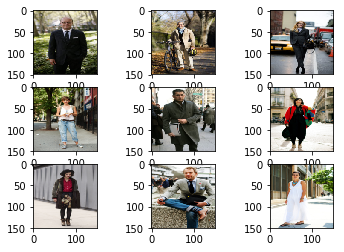

evaluatio dataset


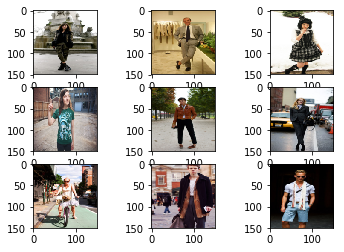

training dataset


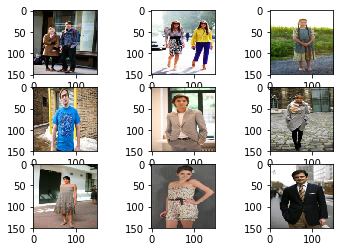

In [20]:
def plot_first_n_images(img_list=img_list,n=9):
    # load data  
    # create a grid of 3x3 images
    for i in range(0, n):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(img_list[i])
    # show the plot
    pyplot.show()
    
print "consolidated dataset"
plot_first_n_images(train_data_filter)
print "evaluatio dataset"
plot_first_n_images(train_data_eval)
print "training dataset"
plot_first_n_images(train_data_train)

In [17]:
print (len(train_data_train)* 10)//batch_size
print (len(train_data_eval)* 10)//batch_size

468
144


### We shall now use the ImageDataGenerator in Keras to augment our dataset and increase it's size 10 fold.  Then we shall use VGG16 to learn weights from the 16th layer of VGGNet for our augmented images. Finally we'll save these features to a file 

In [18]:


def save_bottleneck_features(train_data_filter, train_labels_filter, filename = 'bottleneck_features_train.npy'):
    train_data_aug=[]
    train_labels_aug=[]
    
    datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True,
  
        horizontal_flip=True,
        fill_mode='nearest')
    
    model = applications.VGG16(include_top=False, weights='imagenet')
    print "loading gen on training data"
    
    datagen.fit(train_data_filter)
    
    print "generating augmentations of data"
    bottleneck_features_train =[]
    i = 0
    
    print "total num of iters will be " + str((len(train_data_filter) * 10)//batch_size)
  
    for X_batch, y_batch in datagen.flow(train_data_filter, train_labels_filter, batch_size=batch_size, shuffle=False):
        
        train_data_aug.extend(X_batch)
        train_labels_aug.extend(y_batch)
        
        print "in iter ", i
        
        print "generating bottleneck features"
        bottleneck_features_train_batch = model.predict(
        X_batch,  verbose =1)
        
        print bottleneck_features_train_batch.shape
        print len(train_data_aug)
        
        bottleneck_features_train.extend(bottleneck_features_train_batch)
        i += 1
        
        if i > (len(train_data_filter) * 10)//batch_size:
            break
            
    bottleneck_features_train = np.array(bottleneck_features_train)
    train_data_aug = np.array(train_data_aug)
    train_labels_aug = np.array(train_labels_aug)
    
    print bottleneck_features_train.shape
    print train_data_aug.shape
    print train_labels_aug.shape 
    print "saving bottleneck features to a file"
    np.save(open(filename, 'w'),
        bottleneck_features_train)
    
    return train_data_aug, train_labels_aug, bottleneck_features_train

    
print "saving bottleneck features and augmented data for train data "
train_data_aug, train_labels_aug, bottleneck_features_train = save_bottleneck_features(train_data_train, train_label_train, 'bottleneck_features_train_v16.npy')

    
print "saving bottleneck features and augmented data for eval data "
eval_data_aug, eval_labels_aug, bottleneck_features_eval = save_bottleneck_features(train_data_eval, train_label_eval, 'bottleneck_features_eval_v16.npy')

saving bottleneck features and augmented data for train data 
loading gen on training data
generating augmentations of data
total num of iters will be 468
in iter  0
generating bottleneck features
18/18 [==============================] - 8s 452ms/step
(18, 4, 4, 512)
18
in iter  1
generating bottleneck features
18/18 [==============================] - 7s 379ms/step
(18, 4, 4, 512)
36
in iter  2
generating bottleneck features
18/18 [==============================] - 7s 404ms/step
(18, 4, 4, 512)
54
in iter  3
generating bottleneck features
18/18 [==============================] - 7s 407ms/step
(18, 4, 4, 512)
72
in iter  4
generating bottleneck features
18/18 [==============================] - 7s 417ms/step
(18, 4, 4, 512)
90
in iter  5
generating bottleneck features
18/18 [==============================] - 7s 386ms/step
(18, 4, 4, 512)
108
in iter  6
generating bottleneck features
18/18 [==============================] - 7s 415ms/step
(18, 4, 4, 512)
126
in iter  7
generating bottlenec

18/18 [==============================] - 7s 379ms/step
(18, 4, 4, 512)
1240
in iter  69
generating bottleneck features
18/18 [==============================] - 7s 385ms/step
(18, 4, 4, 512)
1258
in iter  70
generating bottleneck features
18/18 [==============================] - 7s 384ms/step
(18, 4, 4, 512)
1276
in iter  71
generating bottleneck features
18/18 [==============================] - 7s 401ms/step
(18, 4, 4, 512)
1294
in iter  72
generating bottleneck features
18/18 [==============================] - 7s 379ms/step
(18, 4, 4, 512)
1312
in iter  73
generating bottleneck features
18/18 [==============================] - 7s 381ms/step
(18, 4, 4, 512)
1330
in iter  74
generating bottleneck features
18/18 [==============================] - 7s 383ms/step
(18, 4, 4, 512)
1348
in iter  75
generating bottleneck features
18/18 [==============================] - 7s 391ms/step
(18, 4, 4, 512)
1366
in iter  76
generating bottleneck features
18/18 [==============================] - 7s 379m

18/18 [==============================] - 8s 434ms/step
(18, 4, 4, 512)
2480
in iter  138
generating bottleneck features
18/18 [==============================] - 7s 384ms/step
(18, 4, 4, 512)
2498
in iter  139
generating bottleneck features
18/18 [==============================] - 7s 393ms/step
(18, 4, 4, 512)
2516
in iter  140
generating bottleneck features
16/16 [==============================] - 6s 387ms/step
(16, 4, 4, 512)
2532
in iter  141
generating bottleneck features
18/18 [==============================] - 7s 373ms/step
(18, 4, 4, 512)
2550
in iter  142
generating bottleneck features
18/18 [==============================] - 8s 422ms/step
(18, 4, 4, 512)
2568
in iter  143
generating bottleneck features
18/18 [==============================] - 8s 430ms/step
(18, 4, 4, 512)
2586
in iter  144
generating bottleneck features
18/18 [==============================] - 7s 408ms/step
(18, 4, 4, 512)
2604
in iter  145
generating bottleneck features
18/18 [==============================] -

(18, 4, 4, 512)
3700
in iter  206
generating bottleneck features
18/18 [==============================] - 6s 360ms/step
(18, 4, 4, 512)
3718
in iter  207
generating bottleneck features
18/18 [==============================] - 7s 371ms/step
(18, 4, 4, 512)
3736
in iter  208
generating bottleneck features
18/18 [==============================] - 7s 372ms/step
(18, 4, 4, 512)
3754
in iter  209
generating bottleneck features
18/18 [==============================] - 8s 434ms/step
(18, 4, 4, 512)
3772
in iter  210
generating bottleneck features
18/18 [==============================] - 8s 441ms/step
(18, 4, 4, 512)
3790
in iter  211
generating bottleneck features
18/18 [==============================] - 7s 403ms/step
(18, 4, 4, 512)
3808
in iter  212
generating bottleneck features
18/18 [==============================] - 8s 453ms/step
(18, 4, 4, 512)
3826
in iter  213
generating bottleneck features
18/18 [==============================] - 9s 491ms/step
(18, 4, 4, 512)
3844
in iter  214
genera

18/18 [==============================] - 6s 353ms/step
(18, 4, 4, 512)
4940
in iter  275
generating bottleneck features
18/18 [==============================] - 7s 400ms/step
(18, 4, 4, 512)
4958
in iter  276
generating bottleneck features
18/18 [==============================] - 8s 445ms/step
(18, 4, 4, 512)
4976
in iter  277
generating bottleneck features
18/18 [==============================] - 7s 395ms/step
(18, 4, 4, 512)
4994
in iter  278
generating bottleneck features
18/18 [==============================] - 7s 371ms/step
(18, 4, 4, 512)
5012
in iter  279
generating bottleneck features
18/18 [==============================] - 6s 360ms/step
(18, 4, 4, 512)
5030
in iter  280
generating bottleneck features
18/18 [==============================] - 6s 352ms/step
(18, 4, 4, 512)
5048
in iter  281
generating bottleneck features
16/16 [==============================] - 6s 354ms/step
(16, 4, 4, 512)
5064
in iter  282
generating bottleneck features
18/18 [==============================] -

(18, 4, 4, 512)
6160
in iter  343
generating bottleneck features
18/18 [==============================] - 8s 459ms/step
(18, 4, 4, 512)
6178
in iter  344
generating bottleneck features
18/18 [==============================] - 8s 441ms/step
(18, 4, 4, 512)
6196
in iter  345
generating bottleneck features
18/18 [==============================] - 7s 371ms/step
(18, 4, 4, 512)
6214
in iter  346
generating bottleneck features
18/18 [==============================] - 6s 358ms/step
(18, 4, 4, 512)
6232
in iter  347
generating bottleneck features
18/18 [==============================] - 7s 366ms/step
(18, 4, 4, 512)
6250
in iter  348
generating bottleneck features
18/18 [==============================] - 6s 358ms/step
(18, 4, 4, 512)
6268
in iter  349
generating bottleneck features
18/18 [==============================] - 6s 358ms/step
(18, 4, 4, 512)
6286
in iter  350
generating bottleneck features
18/18 [==============================] - 6s 353ms/step
(18, 4, 4, 512)
6304
in iter  351
genera

18/18 [==============================] - 8s 427ms/step
(18, 4, 4, 512)
7400
in iter  412
generating bottleneck features
18/18 [==============================] - 8s 441ms/step
(18, 4, 4, 512)
7418
in iter  413
generating bottleneck features
18/18 [==============================] - 7s 407ms/step
(18, 4, 4, 512)
7436
in iter  414
generating bottleneck features
18/18 [==============================] - 7s 401ms/step
(18, 4, 4, 512)
7454
in iter  415
generating bottleneck features
18/18 [==============================] - 7s 395ms/step
(18, 4, 4, 512)
7472
in iter  416
generating bottleneck features
18/18 [==============================] - 7s 380ms/step
(18, 4, 4, 512)
7490
in iter  417
generating bottleneck features
18/18 [==============================] - 8s 449ms/step
(18, 4, 4, 512)
7508
in iter  418
generating bottleneck features
18/18 [==============================] - 8s 420ms/step
(18, 4, 4, 512)
7526
in iter  419
generating bottleneck features
18/18 [==============================] -

18/18 [==============================] - 9s 491ms/step
(18, 4, 4, 512)
180
in iter  10
generating bottleneck features
18/18 [==============================] - 8s 438ms/step
(18, 4, 4, 512)
198
in iter  11
generating bottleneck features
18/18 [==============================] - 9s 485ms/step
(18, 4, 4, 512)
216
in iter  12
generating bottleneck features
18/18 [==============================] - 8s 423ms/step
(18, 4, 4, 512)
234
in iter  13
generating bottleneck features
18/18 [==============================] - 8s 421ms/step
(18, 4, 4, 512)
252
in iter  14
generating bottleneck features
8/8 [==============================] - 3s 371ms/step
(8, 4, 4, 512)
260
in iter  15
generating bottleneck features
18/18 [==============================] - 7s 407ms/step
(18, 4, 4, 512)
278
in iter  16
generating bottleneck features
18/18 [==============================] - 9s 483ms/step
(18, 4, 4, 512)
296
in iter  17
generating bottleneck features
18/18 [==============================] - 7s 409ms/step
(18,

(18, 4, 4, 512)
1372
in iter  79
generating bottleneck features
18/18 [==============================] - 9s 492ms/step
(18, 4, 4, 512)
1390
in iter  80
generating bottleneck features
18/18 [==============================] - 8s 449ms/step
(18, 4, 4, 512)
1408
in iter  81
generating bottleneck features
18/18 [==============================] - 6s 360ms/step
(18, 4, 4, 512)
1426
in iter  82
generating bottleneck features
18/18 [==============================] - 6s 360ms/step
(18, 4, 4, 512)
1444
in iter  83
generating bottleneck features
18/18 [==============================] - 8s 439ms/step
(18, 4, 4, 512)
1462
in iter  84
generating bottleneck features
18/18 [==============================] - 7s 393ms/step
(18, 4, 4, 512)
1480
in iter  85
generating bottleneck features
18/18 [==============================] - 7s 367ms/step
(18, 4, 4, 512)
1498
in iter  86
generating bottleneck features
18/18 [==============================] - 6s 360ms/step
(18, 4, 4, 512)
1516
in iter  87
generating bott

In [21]:
print bottleneck_features_train.shape
print bottleneck_features_eval.shape
print train_data_aug.shape
print train_labels_aug.shape
print eval_data_aug.shape
print eval_labels_aug.shape

(8424, 4, 4, 512)
(2520, 4, 4, 512)
(8424, 150, 150, 3)
(8424,)
(2520, 150, 150, 3)
(2520,)


In [22]:
print "flattening our data after transfer learning and applying PCA to get 1000 most discriminative features"

import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import pickle

# PCA
def pca(train_data_flat, num_features):
    import numpy as np
    from sklearn.decomposition import PCA

   
    pca = PCA(n_components=num_features)
    pca.fit(train_data_flat)

#     print(pca.explained_variance_ratio_)  
#     print(pca.singular_values_)  

    train_data_flat_pca = pca.transform(train_data_flat)
    print train_data_flat_pca.shape
    
    return train_data_flat_pca


flattening our data after transfer learning and applying PCA to get 1000 most discriminative features


### The features from VGGNet are very rich, but also very high in dimension ( 8192) . Since the size of our data is small, we shall be applying PCA to get the first 1000 more discriminative features. We chose the value 1000, after running hit and trial on a number of feature sizes  to see which one produced the best evaluation metrics  

In [33]:
# we can load features from the file when running on 
#train_data = np.load(open('bottleneck_features_train_v16.npy'))
#print train_data.shape

train_data_flat = np.reshape(bottleneck_features_train, (8424, 8192))
train_data_flat_pca = pca(train_data_flat, 2000)

eval_data_flat = np.reshape(bottleneck_features_eval, ( 2520 ,8192))
eval_data_flat_pca= pca(eval_data_flat, 2000)

print train_data_flat.shape
print train_data_flat_pca.shape

print eval_data_flat.shape
print eval_data_flat_pca.shape


#train_data_flat_pca2, train_labels_aug2 = shuffle_data(train_data_flat_pca, train_labels_aug)

(8424, 2000)
(2520, 2000)
(8424, 8192)
(8424, 2000)
(2520, 8192)
(2520, 2000)


### defining our eval metrics, this includes accuracy , confusion metrics and f-score

In [35]:
print "defining our eval metrics, this includes accuracy , confusion metrics and f-score"
from sklearn.metrics import f1_score
# train_label_train = train_label_filter2[:844]
# train_label_eval = train_label_filter2[844:]
#Compute one level accuaracy
def accuracy(matrix):
    return (np.trace(matrix)) * 1.0 / np.sum(matrix)

def eval_metrics(clf, x_eval=eval_data_flat_pca  ,y_eval=eval_labels_aug ):
    pred = clf.predict(x_eval)
    print confusion_matrix(y_eval, pred)
    print accuracy(confusion_matrix(y_eval, pred))
    print f1_score(y_eval, pred, average= 'micro')
    print f1_score(y_eval, pred, average= 'macro')
    print f1_score(y_eval, pred, average= 'weighted')
    

defining our eval metrics, this includes accuracy , confusion metrics and f-score


### We will now use the model with pre-trained weights and train them with a linear classifier . Since we've used augmentation with zero mean and PCA, we can't use Naive Bayes (doesn't take negative values) .  The algorithms we'll test against are :
### 1. Logistic Regression
### 2. SVM ( Use grid search to find the best params and predict with the given parameters)
### 3. Random Forest

#### Running logistic Regression

In [36]:
print "running logistic classifier"

from sklearn import linear_model
def lr(train_data, label):
    logistic_clf = linear_model.LogisticRegression(penalty="l2", class_weight="balanced", max_iter=100, verbose=1)
    logistic_clf.fit(train_data, label)
    return logistic_clf



running logistic classifier
[LibLinear][[ 33  12  57  74  73  14  86]
 [ 19   5   4  60  43   0  69]
 [ 21  10 125  10  21   0  17]
 [ 48  35  24 168 136  15 101]
 [ 70  34  88 101 177  10  52]
 [  5  25   0  24  15   0  47]
 [ 11  16  47  90 106  13 309]]
0.324206349206
0.324206349206
0.246992556329
0.304125898812


In [ ]:
clf =lr(train_data_flat_pca, train_labels_aug)
eval_metrics(clf)

#### running  SVM, first selecting the best parameters using Grid Search then using those params to evaluate results 


In [ ]:

from sklearn.grid_search import GridSearchCV
def svm(train_data, train_labels_augmented):
    from sklearn import svm
    svc = svm.SVC(C=0.5, kernel='linear')
    param_grid = [
          {'C': [0.5, 1, 5], 'kernel': ['linear']},
          {'C': [0.1, 1, 5], 'gamma': [0.001], 'kernel': ['rbf']},
         ]
    kernel = ['linear', 'rbf']
    Cs = [0.1, 0.3, 1]    
    clf = GridSearchCV(estimator=svc, param_grid=param_grid, cv=10, n_jobs=-1,)
    clf.fit(train_data, train_labels_augmented)
    print(clf.best_score_)
    print(clf.best_estimator_.C)
    print(clf.best_estimator_.kernel)
    print(clf.best_params_)
    

cv_results_ = svm(train_data_flat_pca, train_labels_aug)

In [38]:
def svm_best(train_data, label):
    from sklearn import svm
    clf = svm.SVC(C=5, kernel='rbf', gamma = 0.001)
    clf.fit(train_data, label)
    return clf
    

clf =svm_best(train_data_flat_pca, train_labels_aug)
eval_metrics(clf)
    


[[ 33   0  10  95  71   0 140]
 [ 33   5   0  60  33   0  69]
 [ 35   0 106  15  26   0  22]
 [ 23   7  13 245 133   0 106]
 [104   0   0 113 239   7  69]
 [  5  13   0  31  10   0  57]
 [  7   9   0 102 125   0 349]]
0.387698412698
0.387698412698
0.301418773012
0.359817257017


#### Running Random Forest using Grid Search to get classifier with best performance. Since the outputs in grid search don't do better than LR and SVM , we don't go forward with evaluation

In [ ]:
from sklearn.ensemble import RandomForestClassifier
def random_forest(X, y):
    k_fold = 10
    kf_total = KFold(n_splits=k_fold)
    forest = RandomForestClassifier(n_estimators=250,
                                  random_state=0)
    #estimators_list = [50, 100, 150, 250, 500, 800, 1000]  
    estimators_list = [50, 150, 500]  
    clf_forest = GridSearchCV(estimator=forest, param_grid=dict(n_estimators=estimators_list, warm_start=[True, False]), cv=k_fold, n_jobs=-1)
    cms = [confusion_matrix(eval_labels_aug, clf_forest.fit(X,y).predict(eval_data_flat_pca)) for train, test in kf_total.split(X)]
    accuracies = []
    for cm in cms:
        accuracies.append(accuracy(cm))
    print(accuracies)
    print(np.mean(accuracies))

random_forest(train_data_flat_pca, train_labels_aug)

# End of code in notebook 

Auxillary methods to load data from  pickle files 

In [ ]:
import pickle
file = open('train_label_8754.pkl', 'wb')

# # Pickle dictionary using protocol 0.
pickle.dump(train_labels_aug, file)
file.close()
file = open('train_data_8754.pkl', 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(train_data_aug, file)
file.close()


In [ ]:
def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [ ]:
with open('train_data.pkl', 'rb') as f:
    train_data_augmented = pickle.load(f)
    
train_data_augmented.shape,

In [ ]:
with open('train_label.pkl', 'rb') as f:
    train_labels_augmented = pickle.load(f)
train_labels_augmented.shape